# Predicting YouTube Video Views: A Model Training Guide

-------------------------------------------------------------
Notebook created by Marcelo Amaral.
Assisted by GPT, a language model developed by OpenAI. Aug 2023
-------------------------------------------------------------

## Introduction

In the vast realm of digital content, YouTube stands out as a primary platform for video sharing and consumption. With countless creators uploading videos every day, understanding the dynamics of video popularity becomes crucial. In this tutorial, we will embark on a journey to predict YouTube video view counts based on various metadata, such as video titles and subscriber counts.

To accomplish this, we'll leverage a suite of powerful tools and libraries:

    Pandas for data manipulation and analysis.
    Transformers and Sentence Transformers for harnessing the might of pre-trained models, facilitating our exploration into the world of Natural Language Processing.
    Torch to work with neural networks and deep learning.
    Scikit-learn for clustering and metric computations, enabling us to understand the underlying patterns in our data.
    Langchain to assist with loading and processing text documents.
    Matplotlib and Seaborn for visualizing our data and results, offering insights into the intricate patterns of YouTube popularity.
    And lastly, our custom qgr_data_processing package to streamline specific data operations tailored for this project.

Join us as we delve into the intricacies of YouTube metadata, build predictive models, and uncover the secrets behind video views!

In [52]:
from sentence_transformers import SentenceTransformer
import logging
import pandas as pd
import numpy as np
import re
import ast
from datetime import timezone, datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import joblib

In [2]:
from packages import qgr_data_processing as qgr

## Processing Data

Processing the raw data is a crucial step before any analysis or modeling. We'll start by loading our dataset and then preprocess specific columns to make them more manageable and interpretable.

In [3]:
# Load the pre-trained SBERT model
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
sbert_model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1') 

In [4]:
# Function to convert duration to seconds
def duration_to_seconds(duration_str):
    """Converts ISO 8601 duration format into seconds."""
    hours = 0
    minutes = 0
    seconds = 0

    # Extract hours, minutes, and seconds
    hour_match = re.search(r'(\d+)H', duration_str)
    minute_match = re.search(r'(\d+)M', duration_str)
    second_match = re.search(r'(\d+)S', duration_str)

    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))
    if second_match:
        seconds = int(second_match.group(1))

    return hours * 3600 + minutes * 60 + seconds


In [5]:
# Function to convert tags to a vector
def tags_to_vector(tags, model, embedding_size):
    """
    Convert a list of tags into a single vector by averaging the embeddings of individual tags.
    """
    if not tags:
        return [0] * embedding_size
    
    # Convert each tag to a vector
    tag_vectors = [qgr.convertToVector(tag, model, embedding_size) for tag in tags]
    
    # Average the vectors
    avg_vector = np.mean(tag_vectors, axis=0)
    
    return avg_vector.tolist()


In [16]:
# Processing data
# Set up basic logging to catch any errors during data processing
logging.basicConfig(level=logging.ERROR)

# Load the video data from an Excel file
video_table = pd.read_excel('data/YT_data_sample_video_enriched.xlsx')  # Replace with your database; the larger, the better

# Check if the data was loaded correctly
if video_table.empty:
    print("No data loaded from Excel file.")
else:
    print(f"Successfully loaded {video_table.shape[0]} records from the Excel file.")

# Convert the duration column to seconds for uniformity and easier calculations
video_table['duration_seconds'] = video_table['duration'].apply(duration_to_seconds)

# Parse the tags column to extract individual tags
# The tags are stored as a string representation of a list, so we use ast.literal_eval to convert them back to lists
video_table['tags'] = video_table['tags'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# Display the processed columns to confirm our transformations
video_table[['tags', 'duration_seconds']].head()


Successfully loaded 182 records from the Excel file.


,tags,duration_seconds
0,[],60
1,[],60
2,"[simulation, simulation hypothesis, self-simul...",81
3,"[Consciousness, artificial intelligence, deep ...",267
4,"[Consciousness, artificial intelligence, deep ...",1599


In [18]:
channel_table = pd.read_excel('data/YT_data_sample_channel.xlsx')
print(channel_table.columns)

Index(['channelId', 'channelTitle', 'description', 'publishedAt', 'videoCount',
       'viewCount', 'subscriberCount', 'country', 'customUrl',
       'topicCategories', 'madeForKids', 'keywords', 'hasVideoTrending',
       'numberVideoTrending'],
      dtype='object')


In [19]:
# Convert the 'publishedAt' column to datetime format
video_table['publishedAt'] = pd.to_datetime(video_table['publishedAt'])

In [20]:
# Display the head of the DataFrame with the new column
video_table[['publishedAt']].head()

,publishedAt
0,2023-07-24 18:58:59+00:00
1,2023-07-17 23:17:10+00:00
2,2023-06-23 23:55:45+00:00
3,2023-05-17 16:00:00+00:00
4,2023-05-08 18:03:24+00:00


In [26]:
# Set current_date to be timezone-aware (UTC)
current_date = datetime.now(timezone.utc)

# Calculate the number of days since the video was published
video_table['days_since_published'] = (current_date - video_table['publishedAt']).dt.days

# Extract month and day of week from the 'publishedAt' column
video_table['publication_month'] = video_table['publishedAt'].dt.month
video_table['day_of_week'] = video_table['publishedAt'].dt.dayofweek  # Monday=0, Sunday=6

# Display the head of the DataFrame with the new columns
video_table[['publishedAt', 'days_since_published', 'publication_month', 'day_of_week']].head()


,publishedAt,days_since_published,publication_month,day_of_week
0,2023-07-24 18:58:59+00:00,72,7,0
1,2023-07-17 23:17:10+00:00,78,7,0
2,2023-06-23 23:55:45+00:00,102,6,4
3,2023-05-17 16:00:00+00:00,140,5,2
4,2023-05-08 18:03:24+00:00,149,5,0


In [27]:
print(video_table['tags'].iloc[0])

[]


In [29]:
# Create a mapping from channelId to subscriberCount
channel_subscriber_mapping = dict(zip(channel_table['channelId'], channel_table['subscriberCount']))

# Create a DataFrame to store the processed data with additional features
processed_video_table_with_features = pd.DataFrame()

# Iterate over each row in the video_table DataFrame
for _, video in video_table.iterrows():
    video_title = video['title']

    # Check for meaningful title length
    if len(video_title) > 30:
        content_vector_element = qgr.convertToVector(video_title, sbert_model, 384)
        tags_vector_element = tags_to_vector(video['tags'], sbert_model, 384)
        
        viewCount = video['viewCount']  # Directly extract the value
        days_since_published = video['days_since_published']
        duration_seconds = video['duration_seconds']
        publication_month = video['publication_month']
        day_of_week = video['day_of_week']

        # Get subscriberCount using channelId
        subscriberCount = channel_subscriber_mapping.get(video['channelId'], np.nan)  # Use np.nan as default if channelId not found

        # Create a video row with all the features
        video_row = {
            'videoId': video['videoId'],
            'viewCount': viewCount,
            'title': video_title,
            'content_vector': content_vector_element,
            'tags_vector': tags_vector_element,
            'days_since_published': days_since_published,
            'duration_seconds': duration_seconds,
            'publication_month': publication_month,
            'day_of_week': day_of_week,
            'subscriberCount': subscriberCount  # Add subscriberCount here
        }
        
        new_row = pd.DataFrame([video_row])
        processed_video_table_with_features = pd.concat([processed_video_table_with_features, new_row], ignore_index=True)

# Save the newly processed table to an Excel file
processed_video_table_with_features.to_excel('data/YT_data_sample_video_enriched_vector_features.xlsx', index=False)


In [30]:
processed_video_table = pd.read_excel('data/YT_data_sample_video_enriched_vector_features.xlsx')
print(processed_video_table.head())
print("Total number of rows:", processed_video_table.shape[0])

       videoId  viewCount                                              title  \
0  EzwQOdg8Tl4       2326     Exploring The Unification of Spirit and Matter   
1  cE8J0g6l6xE       3968              Is Consciousness Connected Over Time?   
2  jqxYa8fktEc       3265  Exploring The Self-Simulation Hypothesis & Nat...   
3  2UiYlwHS8LI      10679  Trailer for Klee Irwin's "Are We In A Simulati...   
4  tY7bkxxwhqE       1562  كلي إيروين - هل نحن في محاكاة؟ - الجزء 4 - فرض...   

                                      content_vector  \
0  [-0.01433632243424654, 0.031085586175322533, -...   
1  [0.016870219260454178, -0.040848784148693085, ...   
2  [-0.025478752329945564, -0.0526980496942997, -...   
3  [-0.09087289869785309, -0.09601858258247375, -...   
4  [0.05595903471112251, 0.056695710867643356, -0...   

                                         tags_vector  days_since_published  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                    72   
1  [0, 0, 0, 0, 0, 0, 0, 0

The test_size and random_state parameters used in the train_test_split function have specific meanings:

    test_size: This parameter determines the proportion of the dataset to be used as the test set. When set to 0.2, it means that 20% of the data will be set aside for testing, and the remaining 80% will be used for training. You can adjust this value depending on how you want to split your data. For example, if you set test_size to 0.3, it would split the data into 70% for training and 30% for testing.

    random_state: This parameter is used to control the shuffling of the data before splitting it into training and testing sets. If you use the same integer value for random_state every time you run your code (such as 42), the split will be deterministic, and you'll get the same training and testing sets each time. This can be helpful for reproducibility, especially if you want to share your code or compare results across different runs. If you don't set random_state or set it to None, the split will be different each time you run the code.

In summary, test_size=0.2 means that 20% of the data will be used for testing, and random_state=42 ensures that the splitting is reproducible.

In [31]:
# Convert the 'viewCount' column to numeric, setting errors='coerce' to handle non-numeric values
processed_video_table['viewCount'] = pd.to_numeric(processed_video_table['viewCount'], errors='coerce')

# You can decide to fill NaN values with a specific number, like 0, or drop the rows
processed_video_table['viewCount'].fillna(0, inplace=True)
# Alternatively, to drop rows with NaN values, uncomment the following line:
# processed_video_table.dropna(subset=['viewCount'], inplace=True)

# Now you can calculate the mean
mean_view_count = processed_video_table['viewCount'].mean()
print(f"Mean view count: {mean_view_count}")


Mean view count: 66002.89285714286


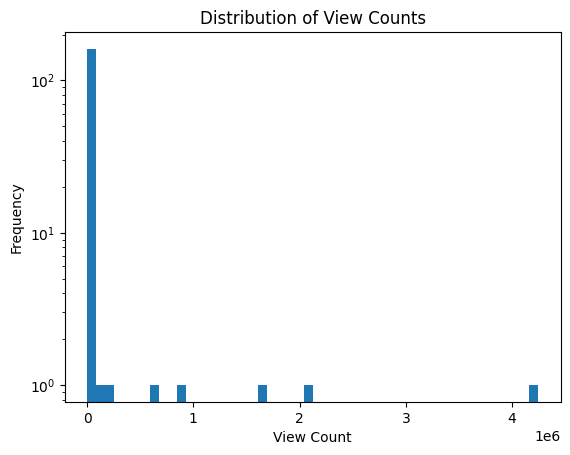

25th percentile: 1765.25
50th percentile: 3385.0
75th percentile: 9162.75
90th percentile: 29237.30000000005
95th percentile: 59945.100000000086


In [34]:
# Extract the view counts
view_counts = processed_video_table['viewCount'].values

# Plot a histogram
plt.hist(view_counts, bins=50, log=True)  # Using log scale for better visualization if there are outliers
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.title('Distribution of View Counts')
plt.show()

# Calculate percentiles
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(view_counts, p)
    print(f"{p}th percentile: {value}")
    

### model

The percentiles you've calculated give you a good understanding of the distribution of view counts in your dataset. Here's a summary:

    25% of the videos have 24,449 views or fewer.
    50% (the median) have 105,342 views or fewer.
    75% have 406,981 views or fewer.
    90% have 1,780,091 views or fewer.
    95% have 4,056,272 views or fewer.

These statistics can help you set a meaningful threshold for categorizing videos as "popular" or not, depending on the context of your analysis or application. For example, you might choose the 75th percentile as a threshold, meaning that videos with more than 406,981 views would be considered popular.

In [35]:
def extract_features(row):
    # Convert the string representation of the list to an actual list
    content_vector = np.array(ast.literal_eval(row['content_vector']))
    tags_vector = np.array(ast.literal_eval(row['tags_vector']))
    
    days_since_published = np.array([row['days_since_published']])
    duration_seconds = np.array([row['duration_seconds']])
    publication_month = np.array([row['publication_month']])
    day_of_week = np.array([row['day_of_week']])
    
    # Extract subscriberCount
    subscriberCount = np.array([row['subscriberCount']])
    
    return np.concatenate([content_vector, tags_vector, days_since_published, duration_seconds, publication_month, day_of_week, subscriberCount])


In [36]:
# Using the extract_features function to create a feature matrix
X = np.array(processed_video_table.apply(extract_features, axis=1).tolist())

# Verify the shape
print(X.shape)

(168, 773)


In [39]:
# Extract the features and target
y = processed_video_table['viewCount'].values

# Convert the features to a proper 2D array shape
#X = np.array(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [40]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(134, 773)
(34, 773)
(134,)
(34,)


Feed-Forward Neural Network (also known as a Dense Neural Network) using TensorFlow and Keras. It's a more appropriate choice than the LSTM if the data isn't sequential in nature.

Here are some observations and suggestions:

    Activation Functions: You're using ReLU (Rectified Linear Unit) activation functions for the dense layers, which is a good choice. ReLU is a common activation function for feed-forward neural networks due to its simplicity and efficiency.

    Dropout & Batch Normalization: Dropout helps in regularizing the network and preventing overfitting. Batch normalization can help in faster convergence and can sometimes act as a regularizer.

    Model Architecture: The architecture seems reasonable for a start. The model starts with 128 neurons and gradually reduces the neuron count in subsequent layers. Depending on the results, you can adjust the model's complexity.

    Callbacks: You've continued using the same set of callbacks - early stopping, model checkpointing, and reducing learning rate on plateau. These are excellent choices and should help in obtaining a better-trained model.

    Training: You're training the model with the same setup, which is good. Depending on the results, you might adjust the batch size or even the learning rate.

    Evaluation: You're still using mean absolute error (MAE) as the loss function, which is appropriate for regression tasks. After training, you're evaluating the model on the test set.

    Saving the Model: You've added code to save the trained model, which is a good practice. This way, you can load the model later without having to retrain it.

Suggestions:

    Data Preprocessing: Ensure that the features are normalized or standardized before feeding them into the neural network. Neural networks tend to perform better with normalized data.

    Model Complexity: Depending on the results, you might want to adjust the model's complexity. If you notice overfitting, consider reducing the number of neurons or layers. Conversely, if the model underfits, you can increase its complexity.

    Learning Rate: Sometimes, adjusting the learning rate can lead to better performance. You might want to experiment with different learning rates or even use a learning rate schedule.

    Visualize Training Progress: Plotting the training and validation loss (and accuracy if you have it) over epochs can provide valuable insights into the training process.

Your current setup looks good for an initial run. After training, based on the results and the visualizations, you can further tweak and optimize the model.

In [41]:
# Apply log transformation to the target variable (view counts)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [50]:
# simpler architecture like feed-forward neural networks.

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3), # Add dropout
    BatchNormalization(), # Add batch normalization
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_absolute_error')

# Early stopping to monitor the validation loss and stop training when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model checkpointing to save the model with the best validation loss
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Reduce learning rate when the validation loss has stopped improving
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# Train the model with the callbacks
model.fit(
    X_train, y_train_log,
    epochs=100, # Increase the number of epochs
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test_log)
print(f"Mean Absolute Error: {loss}")

# Save model
model_path = "data/my_model_yt_features_FFNN_test.h5"
model.save(model_path)

Epoch 1/100


2023-10-04 15:49:51.926545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 15:49:51.926958: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 54ms/step - loss: 7.8936 - val_loss: 1.9046 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 7.5818 - val_loss: 2.7470 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 7.2411 - val_loss: 2.9924 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 6.8555 - val_loss: 2.9320 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 6.3024 - val_loss: 2.7210 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 5.8854 - val_loss: 1.8841 - lr: 0.0010
Epoch 7/100
1/4 [======>.......................] - ETA: 0s - loss: 5.2943

/home/mamaral/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 15ms/step - loss: 5.2508 - val_loss: 1.0963 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 4.5703 - val_loss: 1.4559 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 3.7980 - val_loss: 2.0240 - lr: 0.0010
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 3.0186 - val_loss: 3.0071 - lr: 0.0010
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 2.3279 - val_loss: 4.0805 - lr: 0.0010
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7326 - val_loss: 5.0956 - lr: 0.0010
Epoch 13/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7076 - val_loss: 4.4154 - lr: 1.0000e-04
Epoch 14/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7581 - val_loss: 3.7934 - lr: 1.0000e-04
Epoch 15/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7375 - val_loss: 3.2461 - lr: 1.0000e-04
Epo

In [53]:
# Predict on the test set
y_pred_log = model.predict(X_test)

# Apply the inverse transformation to the predictions
y_pred = np.expm1(y_pred_log)

# Compute the MAE on the original scale
mae_original_scale = mean_absolute_error(y_test, y_pred.flatten())

print(f"Mean Absolute Error on original scale: {mae_original_scale}")


2/2 [==============================] - 0s 2ms/step
Mean Absolute Error on original scale: 1.2425944913671862e+25


A baseline comparison is used to provide a reference point for evaluating the performance of your model. It helps you understand whether the complexity of your model is providing any benefit compared to simpler, heuristic-based approaches. Common baseline models include predicting the mean, median, or mode of the target variable for all observations.

Here's how you can create a baseline comparison using the mean and median of the view counts:

    Mean Baseline:
        Compute the mean of the training target variable (y_train).
        Create predictions for the test set by assigning this mean value to all the observations.
        Compute the Mean Absolute Error (MAE) between these constant predictions and the actual values in the test set (y_test).

    Median Baseline:
        Similar to the mean baseline, but using the median of the training target variable instead.

In [54]:
# Mean Baseline
mean_view_count = np.mean(y_train)
mean_predictions = np.full_like(y_test, mean_view_count)
mean_baseline_mae = mean_absolute_error(y_test, mean_predictions)
print(f"Mean Baseline MAE: {mean_baseline_mae}")

# Median Baseline
median_view_count = np.median(y_train)
median_predictions = np.full_like(y_test, median_view_count)
median_baseline_mae = mean_absolute_error(y_test, median_predictions)
print(f"Median Baseline MAE: {median_baseline_mae}")


Mean Baseline MAE: 86577.91176470589
Median Baseline MAE: 31605.91176470588


For data ~100K videos:
The results indicate that:

    Model's MAE on the original scale: 853,336.44853,336.44
    Mean Baseline MAE: 1,216,206.791,216,206.79
    Median Baseline MAE: 848,345.63848,345.63

Your neural network model's performance (MAE of 853,336.44853,336.44) is significantly better than the mean baseline (a basic model that always predicts the mean view count of the training set) but is quite close to the median baseline.

Here's a breakdown of the results:

    The mean baseline simply predicts the average view count for all videos. Given its MAE, it's off by about 1.21.2 million views on average.

    The median baseline predicts the median view count for all videos. It's off by about 848,346848,346 views on average, which is very close to the neural network's MAE.

    The neural network's MAE is slightly better than the median baseline, but the improvement might not be significant enough to justify the complexity of the neural network model over a simple median predictor.

Here's what you might consider:

    Model Complexity vs. Benefit: If the neural network's improvement over the median baseline is marginal, you might weigh the benefits of the slightly improved accuracy against the complexity and computational cost of training and deploying the neural network.

    Feature Engineering: Additional features or better preprocessing might help the neural network model differentiate itself from simple baselines. For instance, consider including features that capture temporal trends, video categories, or other metadata.

    Model Type: Given the results, it might be worth exploring other machine learning models, like tree-based models (Random Forest, Gradient Boosting) or linear regression models with regularization, which might provide better interpretability and performance.

    Domain Knowledge: It's crucial to understand the context. If a difference of a few thousand views is significant in the domain of YouTube analytics (given monetization or advertising concerns), then even a slight improvement over the median baseline can be valuable.

In summary, while the neural network model shows some promise, its performance is close to a simple median predictor. It might be worth exploring other modeling strategies, features, or data sources to enhance the model's predictive power.

Sep 12 2023:
Data 189627 videos
Observations:

    The Mean Absolute Error (MAE) of the model on the log-transformed view counts is 1.0339.
    When predictions are transformed back to the original scale, the MAE is 483,753.2263.
    This is a significant improvement compared to the Mean Baseline MAE of 795,839.5542 and the Median Baseline MAE of 525,261.4406.

In essence, the neural network model you've built and trained seems to perform significantly better than naive baselines (mean and median). It's a good practice to compare model performance to such baselines to understand the model's relative performance.

Recommendations:

    While the model is outperforming the naive baselines, there's still room for improvement. You might consider trying different architectures, other types of embeddings, or even ensemble methods.
    If you have more metadata or can extract more features from the video titles or tags, they might help improve the model's performance.
    Feature importance analysis can provide insights into which features are most impactful in predicting view counts.
    A more comprehensive evaluation could involve other metrics like RMSE (Root Mean Squared Error) or R-squared, which can give a sense of the model's predictive accuracy and explanatory power, respectively.

The Feed-Forward Neural Network (also known as Dense Neural Network) you've used has already shown a good performance, especially when compared to the baseline models. However, there are a few strategies you can try to potentially improve its performance:

    Feature Scaling: Neural networks tend to perform better when the input features are scaled. You can use MinMax scaling or Standard scaling on your input features. Remember to fit the scaler only on the training data and then transform both training and test data.

    Architecture Tweaks:
        More Layers: You can try adding more layers to the model to see if it captures more intricate patterns.
        More Neurons: Increase the number of neurons in each layer. However, more neurons mean more parameters, which can lead to overfitting.
        Different Activation Functions: While relu is commonly used, you can also try variants like leaky relu or elu.

    Regularization:
        L1/L2 Regularization: You can add L1 or L2 regularization to the layers to prevent overfitting.
        Increase Dropout: You already have dropout, but you can experiment with different dropout rates.

    Learning Rate Schedule: Instead of reducing the learning rate on a plateau, you can also try a time-based decay or step decay.

    Optimizers: While Adam is a great general-purpose optimizer, you can also try others like RMSprop or Nadam.

    Batch Size: Experiment with different batch sizes. A smaller batch size might offer better generalization at the cost of training time.

    Data Augmentation: While data augmentation is more popular in image processing, there are ways to augment tabular data too. Techniques like SMOTE (for imbalanced datasets), noise addition, or even generating synthetic samples can be explored.

    Feature Engineering: Consider revisiting the feature engineering phase. Maybe there are some other features or interactions between features that the model might find useful.

    Ensemble Methods: Once you have a good model, you can train multiple models and average their predictions. Techniques like bagging can be useful.

    Custom Loss Function: Instead of using mean absolute error, you can define custom loss functions that might be better suited for your specific problem.

Remember, while trying these suggestions, it's essential to keep an eye on both training and validation performance to ensure the model is not overfitting. Always hold out a portion of your data as a validation set (or use cross-validation) to get an unbiased estimate of the model's performance during the tuning process.

In [55]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Save the fitted scaler to a file
joblib.dump(scaler, 'models/my_model_yt_features_FFNN_test_fitted_scaler.pkl')

## Prediction from one saved model

In [56]:
def predict_views(title, tags, days_since_published, duration_seconds, publication_month, day_of_week, subscriberCount):
    # Convert the title and tags to vectors
    content_vector = qgr.convertToVector(title, sbert_model, 384)
    tags_vector = tags_to_vector(tags, sbert_model, 384)

    # Concatenate all the features
    features = np.concatenate([content_vector, tags_vector, 
                               [days_since_published, duration_seconds, publication_month, day_of_week, subscriberCount]])

    # Reshape the features to have a shape of (1, -1) because we're predicting for one sample
    features = features.reshape(1, -1)

    # Scale the features using the scaler
    scaled_features = loaded_scaler.transform(features)

    # Make the prediction
    predicted_log_views = loaded_model.predict(scaled_features)

    # Convert the prediction back from log scale
    predicted_views = np.expm1(predicted_log_views).flatten()[0]

    return predicted_views


In [57]:
# Load the scaler from the saved file
loaded_scaler = joblib.load('models/my_model_yt_features_FFNN_211727traindata_fitted_scaler.pkl')

# Load the saved Keras model
loaded_model = load_model('models/my_model_yt_features_FFNN_211727traindata.h5')


title = "Are We Living in a Simulation?"
tags = ["science"] 
days_since_published = 10
duration_seconds = 5400
publication_month = 9
day_of_week = 7
subscriberCount = 240000

predicted_views = predict_views(title, tags, days_since_published, duration_seconds, publication_month, day_of_week, subscriberCount)
print(f"Predicted views: {predicted_views}")


1/1 [==============================] - 0s 106ms/step
Predicted views: 27839.50390625


In [58]:
title = "These Pools Help Support Half The People On Earth"
tags = ["science","tech"] 
days_since_published = 30 * 30
duration_seconds = 19.23 * 60
publication_month = 1
day_of_week = 1
subscriberCount = 14200000

predicted_views = predict_views(title, tags, days_since_published, duration_seconds, publication_month, day_of_week, subscriberCount)
print(f"Predicted views: {predicted_views}")


1/1 [==============================] - 0s 13ms/step
Predicted views: 12695063.0
